In [1]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [2]:
import findspark
findspark.init()

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import length
from pyspark.sql.types import StringType

from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF, StringIndexer, VectorAssembler
from pyspark.ml.linalg import Vector
from pyspark.ml.classification import NaiveBayes, LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [5]:
spark = SparkSession .builder \
  .master("local[*]")\
  .appName("New-Spark")\
  .config("spark.memory.fraction", 0.8)\
  .config("spark.executor.memory", "10g")\
  .config("spark.driver.memory", "10g")\
  .config("spark.sql.shuffle.partitions" , "800")\
  .config("spark.memory.offHeap.enabled",'true')\
  .config("spark.memory.offHeap.size","10g")\
  .getOrCreate()

In [6]:
# Load data
fake_news = pd.read_csv("../../Data/fake-and-real-news-dataset/Fake.csv")
true_news = pd.read_csv("../../Data/fake-and-real-news-dataset/True.csv")

In [7]:
fake_news.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [8]:
true_news.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [9]:
fake_news['fake'] = 1
true_news['fake'] = 0

In [10]:
news = pd.concat([fake_news, true_news], ignore_index=True)

In [11]:
news['length'] = news['text'].str.len()

In [12]:
news.head()

,title,text,subject,date,fake,length
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1,2893
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1,1898
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1,3597
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1,2774
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1,2346


<AxesSubplot:>

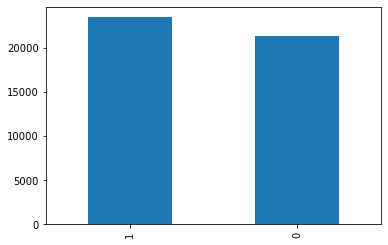

In [13]:
news['fake'].value_counts().plot.bar()

### Tin thật và tin giả có số lượng gần bằng nhau

In [14]:
print("Fake news mean length:", news[news['fake']==1]['length'].mean())
print("True news mean length:", news[news['fake']==0]['length'].mean())

Fake news mean length: 2547.396235254035
True news mean length: 2383.278517065882


### Tin giả có độ dài trung bình lớn hơn tin thật

In [15]:
news.subject.unique()

array(['News', 'politics', 'Government News', 'left-news', 'US_News',
       'Middle-east', 'politicsNews', 'worldnews'], dtype=object)

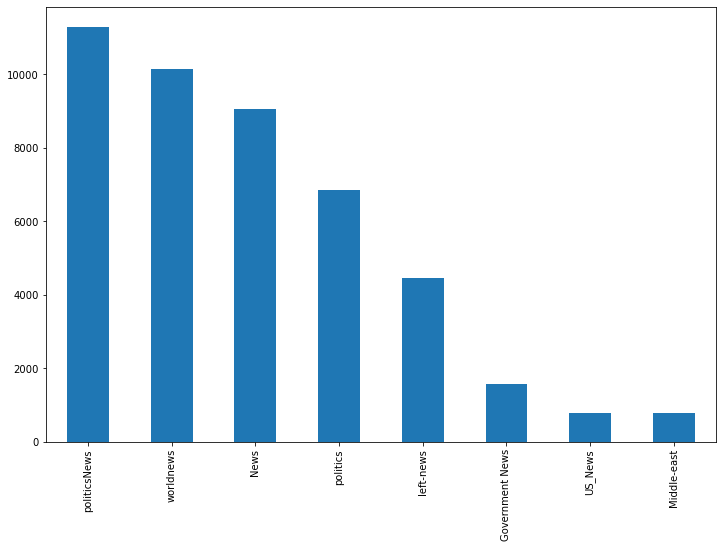

In [16]:
plt.figure(figsize=(12, 8))
news['subject'].value_counts().plot.bar()
plt.show()

In [17]:
data = spark.createDataFrame(news)

In [18]:
data.show(5)

+--------------------+--------------------+-------+-----------------+----+------+
|               title|                text|subject|             date|fake|length|
+--------------------+--------------------+-------+-----------------+----+------+
| Donald Trump Sen...|Donald Trump just...|   News|December 31, 2017|   1|  2893|
| Drunk Bragging T...|House Intelligenc...|   News|December 31, 2017|   1|  1898|
| Sheriff David Cl...|On Friday, it was...|   News|December 30, 2017|   1|  3597|
| Trump Is So Obse...|On Christmas day,...|   News|December 29, 2017|   1|  2774|
| Pope Francis Jus...|Pope Francis used...|   News|December 25, 2017|   1|  2346|
+--------------------+--------------------+-------+-----------------+----+------+
only showing top 5 rows



In [19]:
rating_to_num = StringIndexer(inputCol='fake', outputCol='label')
tokenizer = Tokenizer(inputCol='text', outputCol='token_text')
stopremove = StopWordsRemover(inputCol='token_text', outputCol='stop_tokens')
count_vec = CountVectorizer(inputCol='stop_tokens', outputCol='c_vec')
idf = IDF(inputCol='c_vec', outputCol='tf_idf')
clean_up = VectorAssembler(inputCols=['tf_idf', 'length'], outputCol='features')

In [20]:
data_prep_pipe = Pipeline(stages=[tokenizer, stopremove, count_vec, idf, clean_up, rating_to_num])
clearer = data_prep_pipe.fit(data)
clean_data = clearer.transform(data)

In [21]:
clean_data = clean_data.select(['label', 'features'])

In [22]:
clean_data.show(10)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(262145,[0,1,4,5,...|
|  0.0|(262145,[0,1,2,4,...|
|  0.0|(262145,[0,1,5,6,...|
|  0.0|(262145,[0,1,4,5,...|
|  0.0|(262145,[0,1,2,6,...|
|  0.0|(262145,[0,5,29,3...|
|  0.0|(262145,[0,1,10,2...|
|  0.0|(262145,[0,1,4,5,...|
|  0.0|(262145,[0,1,3,5,...|
|  0.0|(262145,[0,1,4,5,...|
+-----+--------------------+
only showing top 10 rows



In [23]:
(training, testing) = clean_data.randomSplit([0.7, 0.3])

### Naive Bayer

In [24]:
nb = NaiveBayes()

In [25]:
predictor_nb = nb.fit(training)
test_result_nb = predictor_nb.transform(testing)
test_result_nb.groupBy("label", "prediction").count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       1.0|  162|
|  1.0|       0.0|   33|
|  0.0|       0.0| 6808|
|  1.0|       1.0| 6438|
+-----+----------+-----+



In [26]:
acc_eval = MulticlassClassificationEvaluator()

In [27]:
acc_nb = acc_eval.evaluate(test_result_nb)
print("Accuracy of Naive Bayer at predicting was: {}".format(acc_nb))

Accuracy of Naive Bayer at predicting was: 0.9854959867219935


### Logistic Regression

In [28]:
lg = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

In [29]:
predictor_lg = lg.fit(training)
test_result_lg = predictor_lg.transform(testing)
test_result_lg.groupBy("label", "prediction").count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       1.0|   53|
|  1.0|       0.0|   20|
|  0.0|       0.0| 6917|
|  1.0|       1.0| 6451|
+-----+----------+-----+



In [30]:
acc_lg = acc_eval.evaluate(test_result_lg)
print("Accuracy of Logistic Regression model at predicting was: {}".format(acc_lg))

Accuracy of Logistic Regression model at predicting was: 0.9945693193445996


# Logistic Regression cho độ chính xác tốt nhất